In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("4l-TMVA/tree_ewk_mytrain.root")
backgroundFile=TFile.Open("4l-TMVA/tree_QCD_mytrain.root")

In [3]:
signalTree=signalFile.Get("tree_NOMINAL")
backgroundTree=backgroundFile.Get("tree_NOMINAL")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  223401
background events number before cut is:  279340


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
backgroundArray=backgroundTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

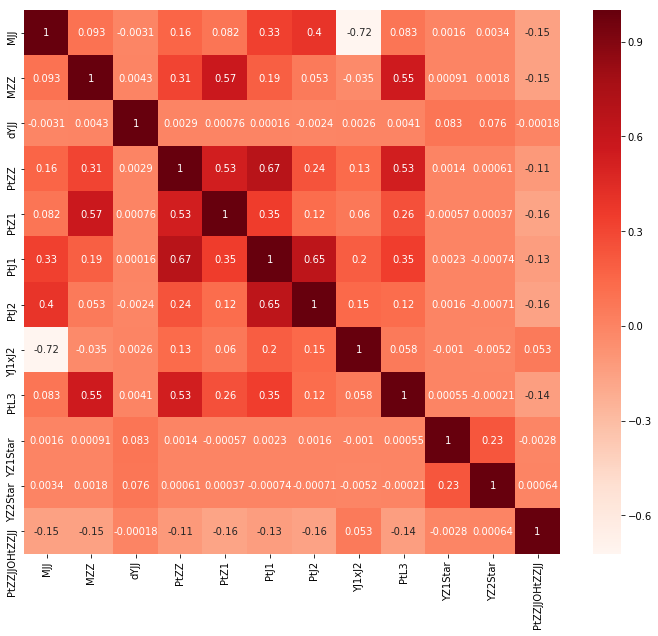

In [7]:
plt.figure(figsize=(12,10))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

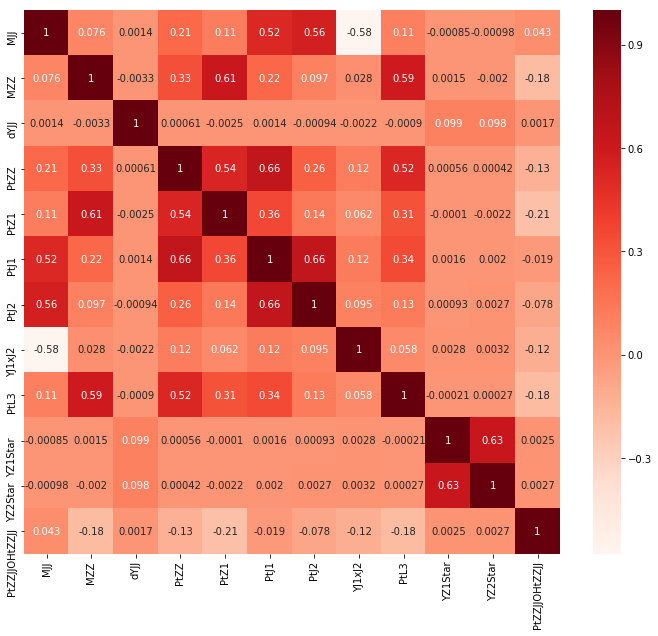

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [9]:
print(signalArray)

[[ 7.93955566e-05  1.10154873e+03  2.21385879e+02 ... -2.03438704e-01
  -7.17892966e-01  2.47319219e-01]
 [ 6.81283983e-05  8.88801935e+02  4.55076482e+02 ...  2.26838329e-01
  -6.34519528e-01  8.35550913e-02]
 [ 7.11882814e-05  1.39131227e+03  4.18144039e+02 ...  1.32187581e+00
  -1.33197312e+00  7.07480238e-02]
 ...
 [ 1.53771444e-04  8.24401842e+02  2.79273295e+02 ...  1.37421096e+00
   3.21475295e-01  2.03029652e-01]
 [ 1.43034199e-04  8.57515774e+02  1.86559830e+02 ... -4.43191963e-01
  -8.43641431e-01  1.82698382e-01]
 [ 2.06428744e-04  2.63357400e+03  3.88897812e+02 ...  9.54711913e-01
   1.37531098e+00  4.99991020e-02]]


In [10]:
print(signalArray[:,1])

[1101.54872881  888.80193472 1391.31226846 ...  824.4018424   857.51577443
 2633.5740049 ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

184569
100683


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  184569
background event number after cut is: 100683


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  147655
testing signal events number is:  36914
training background events number is:  80546
testing background events number is:  20137


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)

[[ 0.00000000e+00  1.24683477e-03  4.15262042e+02 ... -1.16850570e+00
  -1.21058080e-02  3.80503254e-02]
 [ 0.00000000e+00  2.32691743e-03  6.11837685e+02 ... -1.49172995e+00
  -1.47787883e+00  1.36948446e-01]
 [ 0.00000000e+00  1.60391666e-03  5.10663260e+02 ... -1.63159912e+00
  -1.21268799e+00  1.70711543e-01]
 ...
 [ 0.00000000e+00  2.12766180e-03  9.81921016e+02 ...  1.63936373e-01
   1.89255424e+00  5.12158171e-02]
 [ 0.00000000e+00  8.89092390e-04  1.26493593e+03 ... -8.72307436e-02
   1.41444303e+00  1.63736675e-01]
 [ 0.00000000e+00  3.61952304e-03  6.06729492e+02 ... -4.34869950e-01
  -3.75516061e-01  1.24633166e-02]]


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(228201, 12) dtype=float32>

Signal and background training sets should have same yield in training

(array([62.05811568,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 62.05811568]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

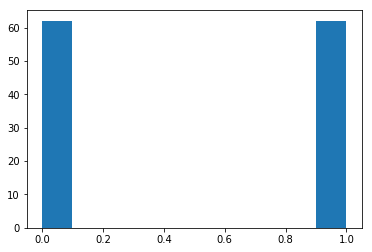

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrain[:,1])

In [18]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

[[0.03930434 0.0280569  0.35407159 ... 0.47419897 0.41963936 0.1606118 ]
 [0.07010625 0.04940195 0.74279831 ... 0.53231936 0.53638065 0.12452646]
 [0.13207531 0.04318547 0.35398912 ... 0.58589167 0.43614512 0.00629771]
 ...
 [0.00115697 0.02131112 0.29221492 ... 0.80805867 0.78510662 0.34679035]
 [0.22997877 0.11156712 0.75462738 ... 0.27732018 0.30322776 0.16167611]
 [0.07698448 0.04413541 0.26226506 ... 0.10834986 0.16334968 0.05470565]]


Build model

In [19]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=12))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [21]:
model.save('model_4lNN.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               3900      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 365,401
Trainable params: 365,401
Non-trainable params: 0
_________________________________________________________________


2019-06-21 00:18:11.929205: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-21 00:18:11.938069: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-21 00:18:11.938841: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5569d5dd94f0 executing computations on platform Host. Devices:
2019-06-21 00:18:11.938875: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-21 00:18:12.068546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-21 00:18:12.068876: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5569d5e8cc60 executing computations on platform CUDA. Devices:
2019-06-21 00:18:12.068893: I t

In [22]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=100, epochs=30,
          sample_weight=dataTrainWeight,
          validation_split=0.2,
          callbacks=[early_stopping])

Train on 182560 samples, validate on 45641 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
182560/182560 [==============================] - 13s 70us/sample - loss: 0.4961 - acc: 0.7398 - val_loss: 0.4745 - val_acc: 0.7627
Epoch 2/30
182560/182560 [==============================] - 11s 59us/sample - loss: 0.4689 - acc: 0.7594 - val_loss: 0.4606 - val_acc: 0.7720
Epoch 3/30
182560/182560 [==============================] - 13s 71us/sample - loss: 0.4623 - acc: 0.7632 - val_loss: 0.4823 - val_acc: 0.7782
Epoch 4/30
182560/182560 [==============================] - 11s 62us/sample - loss: 0.4569 - acc: 0.7651 - val_loss: 0.4728 - val_acc: 0.7348
Epoch 5/30
182560/182560 [==============================] - 11s 59us/sample - loss: 0.4509 - acc: 0.7620 - val_loss: 0.4545 - val_acc: 0.7689
Epoch 6/30
182560/182560 [==============================] - 11s 60us/sample - loss: 0.4545 - acc: 0.7672 - val_loss: 0.4606 - val_acc: 0.7752
Epoch 7/30
182560/182560 [=======================

2019-06-21 00:18:15.904307: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [24]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
print(dataTrainSample1)
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-bakgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[0.03930434 0.0280569  0.35407159 ... 0.47419897 0.41963936 0.1606118 ]
 [0.07010625 0.04940195 0.74279831 ... 0.53231936 0.53638065 0.12452646]
 [0.13207531 0.04318547 0.35398912 ... 0.58589167 0.43614512 0.00629771]
 ...
 [0.00115697 0.02131112 0.29221492 ... 0.80805867 0.78510662 0.34679035]
 [0.22997877 0.11156712 0.75462738 ... 0.27732018 0.30322776 0.16167611]
 [0.07698448 0.04413541 0.26226506 ... 0.10834986 0.16334968 0.05470565]]
[[0.24056991 0.2782547  0.20873124 ... 0.56776604 0.29931715 0.23638323]
 [0.05400878 0.02471575 0.281767   ... 0.45249868 0.54884582 0.0567585 ]
 [0.01387425 0.02636357 0.67585237 ... 0.53860943 0.40094554 0.55899389]
 ...
 [0.03706912 0.02126497 0.70779724 ... 0.62629103 0.64399508 0.14916407]
 [0.01759261 0.03701945 0.30179983 ... 0.1849476  0.37799303 0.11765801]
 [0.03429722 0.01580314 0.69454218 ... 0.44835164 0.45501114 0.01243717]]


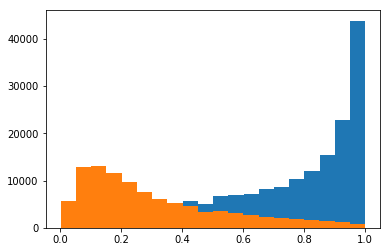

In [25]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

(array([ 5721., 12760., 13024., 11600.,  9632.,  7531.,  6127.,  5283.,
         4665.,  3419.,  3615.,  3093.,  2610.,  2359.,  2027.,  1937.,
         1732.,  1484.,  1245.,   819.]),
 array([0.00217628, 0.05206629, 0.10195629, 0.15184629, 0.20173629,
        0.25162628, 0.3015163 , 0.35140628, 0.4012963 , 0.45118627,
        0.5010763 , 0.55096626, 0.6008563 , 0.6507463 , 0.70063627,
        0.7505263 , 0.8004163 , 0.8503063 , 0.90019625, 0.9500863 ,
        0.9999763 ], dtype=float32),
 <a list of 20 Patch objects>)

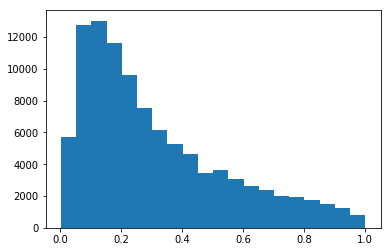

In [26]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [27]:
model.save('model_4lNN.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               3900      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 365,401
Trainable params: 365,401
Non-trainable params: 0
_________________________________________________________________


In [28]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[0.6188664 ]
 [0.8066579 ]
 [0.95102304]
 ...
 [0.54764056]
 [0.6612438 ]
 [0.99325764]]


(array([  896.,  2683.,  3836.,  4718.,  4967.,  4869.,  4832.,  5141.,
         5624.,  5020.,  6796.,  6902.,  7107.,  8188.,  8674., 10315.,
        12042., 15453., 22702., 43804.]),
 array([0.00390342, 0.05370819, 0.10351296, 0.15331772, 0.2031225 ,
        0.25292727, 0.30273205, 0.3525368 , 0.40234157, 0.45214635,
        0.5019511 , 0.5517559 , 0.60156065, 0.6513654 , 0.7011702 ,
        0.75097495, 0.8007797 , 0.8505845 , 0.90038925, 0.95019406,
        0.9999988 ], dtype=float32),
 <a list of 20 Patch objects>)

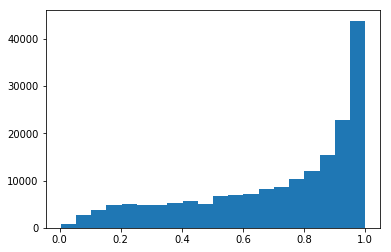

In [29]:
plt.hist(signalNNScore,bins=20)

In [30]:
cuda.select_device(0)
cuda.close()

In [43]:
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight)
BDTSignal=xgb.DMatrix(signalArray[:,1:])
BDTBackground=xgb.DMatrix(backgroundArray[:,1:])
param = {'max_depth': 7, 'eta': 1.0, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [44]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.797437	train-auc:0.797456
[1]	eval-auc:0.827498	train-auc:0.828627
[2]	eval-auc:0.842272	train-auc:0.842626
[3]	eval-auc:0.850325	train-auc:0.85001
[4]	eval-auc:0.853797	train-auc:0.853669
[5]	eval-auc:0.857658	train-auc:0.857996
[6]	eval-auc:0.859249	train-auc:0.860008
[7]	eval-auc:0.860633	train-auc:0.861465
[8]	eval-auc:0.862059	train-auc:0.862897
[9]	eval-auc:0.862808	train-auc:0.863727
[10]	eval-auc:0.86332	train-auc:0.864697
[11]	eval-auc:0.863717	train-auc:0.865322
[12]	eval-auc:0.864151	train-auc:0.865949
[13]	eval-auc:0.864287	train-auc:0.86632
[14]	eval-auc:0.864965	train-auc:0.867227
[15]	eval-auc:0.865328	train-auc:0.867629
[16]	eval-auc:0.865916	train-auc:0.86834
[17]	eval-auc:0.866149	train-auc:0.868717
[18]	eval-auc:0.866711	train-auc:0.86927
[19]	eval-auc:0.866902	train-auc:0.869611
[20]	eval-auc:0.867047	train-auc:0.869921
[21]	eval-auc:0.867267	train-auc:0.870296
[22]	eval-auc:0.867389	train-auc:0.870655
[23]	eval-auc:0.867603	train-auc:0.870937
[24]	ev

[195]	eval-auc:0.871138	train-auc:0.888476
[196]	eval-auc:0.87122	train-auc:0.888507
[197]	eval-auc:0.871228	train-auc:0.888561
[198]	eval-auc:0.871185	train-auc:0.888616
[199]	eval-auc:0.871144	train-auc:0.88867
[200]	eval-auc:0.871246	train-auc:0.888749
[201]	eval-auc:0.871237	train-auc:0.888808
[202]	eval-auc:0.871306	train-auc:0.88888
[203]	eval-auc:0.871255	train-auc:0.88895
[204]	eval-auc:0.871312	train-auc:0.889003
[205]	eval-auc:0.871139	train-auc:0.889081
[206]	eval-auc:0.871175	train-auc:0.889105
[207]	eval-auc:0.871075	train-auc:0.889172
[208]	eval-auc:0.871205	train-auc:0.889259
[209]	eval-auc:0.871109	train-auc:0.889286
[210]	eval-auc:0.871063	train-auc:0.889345
[211]	eval-auc:0.871051	train-auc:0.889463
[212]	eval-auc:0.871152	train-auc:0.889472
[213]	eval-auc:0.871141	train-auc:0.889549
[214]	eval-auc:0.871111	train-auc:0.889582
[215]	eval-auc:0.870957	train-auc:0.889631
[216]	eval-auc:0.871025	train-auc:0.889669
[217]	eval-auc:0.870887	train-auc:0.889741
[218]	eval-auc:

[387]	eval-auc:0.868923	train-auc:0.896606
[388]	eval-auc:0.868844	train-auc:0.896633
[389]	eval-auc:0.869114	train-auc:0.896681
[390]	eval-auc:0.869027	train-auc:0.896697
[391]	eval-auc:0.869032	train-auc:0.896738
[392]	eval-auc:0.868982	train-auc:0.896807
[393]	eval-auc:0.86889	train-auc:0.896813
[394]	eval-auc:0.868878	train-auc:0.896898
[395]	eval-auc:0.868845	train-auc:0.896891
[396]	eval-auc:0.868746	train-auc:0.896914
[397]	eval-auc:0.868865	train-auc:0.896948
[398]	eval-auc:0.86877	train-auc:0.897012
[399]	eval-auc:0.868816	train-auc:0.897018
[400]	eval-auc:0.868826	train-auc:0.897099
[401]	eval-auc:0.868874	train-auc:0.897097
[402]	eval-auc:0.868751	train-auc:0.897123
[403]	eval-auc:0.868769	train-auc:0.897195
[404]	eval-auc:0.868657	train-auc:0.897213
[405]	eval-auc:0.868666	train-auc:0.897231
[406]	eval-auc:0.86859	train-auc:0.897285
[407]	eval-auc:0.868713	train-auc:0.897236
[408]	eval-auc:0.868435	train-auc:0.897319
[409]	eval-auc:0.868433	train-auc:0.897326
[410]	eval-auc

[579]	eval-auc:0.866463	train-auc:0.902557
[580]	eval-auc:0.866351	train-auc:0.902607
[581]	eval-auc:0.866478	train-auc:0.902658
[582]	eval-auc:0.866391	train-auc:0.902674
[583]	eval-auc:0.866367	train-auc:0.902677
[584]	eval-auc:0.866324	train-auc:0.902661
[585]	eval-auc:0.866302	train-auc:0.902653
[586]	eval-auc:0.866144	train-auc:0.902724
[587]	eval-auc:0.866059	train-auc:0.902743
[588]	eval-auc:0.86599	train-auc:0.902743
[589]	eval-auc:0.866056	train-auc:0.902758
[590]	eval-auc:0.866082	train-auc:0.902774
[591]	eval-auc:0.865982	train-auc:0.902824
[592]	eval-auc:0.866025	train-auc:0.902863
[593]	eval-auc:0.866084	train-auc:0.902864
[594]	eval-auc:0.866012	train-auc:0.902908
[595]	eval-auc:0.866009	train-auc:0.902937
[596]	eval-auc:0.865935	train-auc:0.903
[597]	eval-auc:0.865847	train-auc:0.903013
[598]	eval-auc:0.865817	train-auc:0.903025
[599]	eval-auc:0.865913	train-auc:0.903064
[600]	eval-auc:0.865934	train-auc:0.903046
[601]	eval-auc:0.86588	train-auc:0.903131
[602]	eval-auc:0

[771]	eval-auc:0.863013	train-auc:0.907583
[772]	eval-auc:0.863024	train-auc:0.907604
[773]	eval-auc:0.862828	train-auc:0.907634
[774]	eval-auc:0.862799	train-auc:0.907683
[775]	eval-auc:0.8629	train-auc:0.907783
[776]	eval-auc:0.862787	train-auc:0.907748
[777]	eval-auc:0.862954	train-auc:0.907787
[778]	eval-auc:0.862885	train-auc:0.907851
[779]	eval-auc:0.862775	train-auc:0.907896
[780]	eval-auc:0.862748	train-auc:0.907883
[781]	eval-auc:0.86281	train-auc:0.907895
[782]	eval-auc:0.862749	train-auc:0.907881
[783]	eval-auc:0.86256	train-auc:0.907897
[784]	eval-auc:0.86284	train-auc:0.907836
[785]	eval-auc:0.862635	train-auc:0.907932
[786]	eval-auc:0.862658	train-auc:0.907917
[787]	eval-auc:0.862535	train-auc:0.907979
[788]	eval-auc:0.862368	train-auc:0.908012
[789]	eval-auc:0.862341	train-auc:0.908055
[790]	eval-auc:0.862599	train-auc:0.908026
[791]	eval-auc:0.862662	train-auc:0.908087
[792]	eval-auc:0.862513	train-auc:0.908065
[793]	eval-auc:0.862486	train-auc:0.908043
[794]	eval-auc:0

[963]	eval-auc:0.859047	train-auc:0.912153
[964]	eval-auc:0.85908	train-auc:0.912105
[965]	eval-auc:0.859039	train-auc:0.912173
[966]	eval-auc:0.859422	train-auc:0.912139
[967]	eval-auc:0.859187	train-auc:0.912148
[968]	eval-auc:0.859077	train-auc:0.912122
[969]	eval-auc:0.85924	train-auc:0.912147
[970]	eval-auc:0.859354	train-auc:0.912135
[971]	eval-auc:0.859094	train-auc:0.912201
[972]	eval-auc:0.859225	train-auc:0.912336
[973]	eval-auc:0.859246	train-auc:0.912357
[974]	eval-auc:0.859112	train-auc:0.912333
[975]	eval-auc:0.859248	train-auc:0.912306
[976]	eval-auc:0.859274	train-auc:0.912382
[977]	eval-auc:0.859164	train-auc:0.912353
[978]	eval-auc:0.858946	train-auc:0.912398
[979]	eval-auc:0.85894	train-auc:0.912415
[980]	eval-auc:0.859046	train-auc:0.91235
[981]	eval-auc:0.858894	train-auc:0.912419
[982]	eval-auc:0.859085	train-auc:0.912433
[983]	eval-auc:0.858883	train-auc:0.912394
[984]	eval-auc:0.858924	train-auc:0.912461
[985]	eval-auc:0.859082	train-auc:0.912543
[986]	eval-auc:

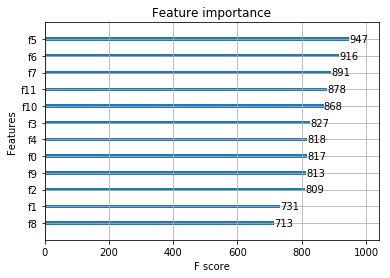

In [45]:
xgb.plot_importance(GBDT)

(array([65289., 52695., 36473., 25819., 20030., 14954., 11865.,  9207.,
         7555.,  6047.,  5220.,  4259.,  3791.,  3316.,  2912.,  2553.,
         2361.,  2040.,  1698.,  1256.]),
 array([4.18092415e-04, 5.03971875e-02, 1.00376286e-01, 1.50355384e-01,
        2.00334474e-01, 2.50313580e-01, 3.00292671e-01, 3.50271761e-01,
        4.00250852e-01, 4.50229943e-01, 5.00209033e-01, 5.50188124e-01,
        6.00167215e-01, 6.50146306e-01, 7.00125456e-01, 7.50104547e-01,
        8.00083637e-01, 8.50062728e-01, 9.00041819e-01, 9.50020909e-01,
        1.00000000e+00], dtype=float32),
 <a list of 20 Patch objects>)

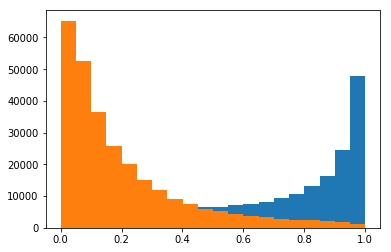

In [46]:
SignalScore=GBDT.predict(BDTSignal)
plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

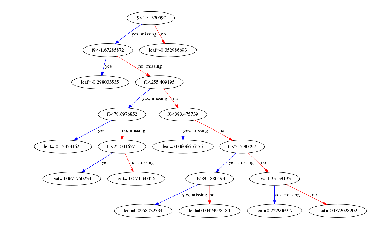

In [47]:
plot_tree(GBDT, num_trees=4)

(array([10910., 12853., 11269.,  9905.,  9267.,  8325.,  7952.,  7455.,
         7245.,  7141.,  7364.,  7384.,  7521.,  8176.,  8968., 10022.,
        11942., 14318., 21004., 39180.]),
 array([4.18092415e-04, 5.03971875e-02, 1.00376286e-01, 1.50355384e-01,
        2.00334474e-01, 2.50313580e-01, 3.00292671e-01, 3.50271761e-01,
        4.00250852e-01, 4.50229943e-01, 5.00209033e-01, 5.50188124e-01,
        6.00167215e-01, 6.50146306e-01, 7.00125456e-01, 7.50104547e-01,
        8.00083637e-01, 8.50062728e-01, 9.00041819e-01, 9.50020909e-01,
        1.00000000e+00], dtype=float32),
 <a list of 20 Patch objects>)

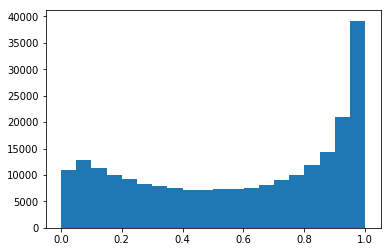

In [48]:
trainScore=GBDT.predict(BDTtrain)
plt.hist(trainScore,bins=20)

In [49]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

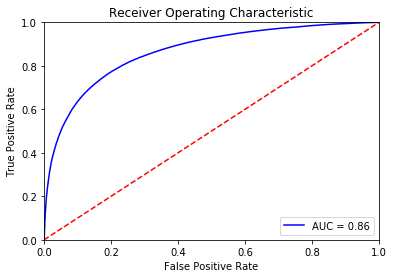

In [50]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

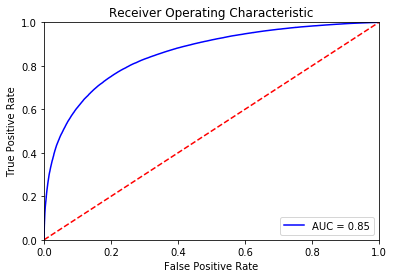

In [51]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_vbszz.pickle.dat", "wb"))